# **Denosiing Diffusion Policy Optimization**

This file is a Colab implementation of DDPO, finetuning Diffusion Model with Reinforcement Learning.

## **A. Text to Image Diffusion Model**
- Pretrained Diffusion Model used for fine-tuning is Stable Diffusion v1.5, which is Text to Image Diffusion Model that generates images related to given user prompt.

- For computational efficiency, Stable Diffusion v 1.5 works in latent space where image is encoded and decoded by Pretrained VAE.



 <figure style="text-align: center">
      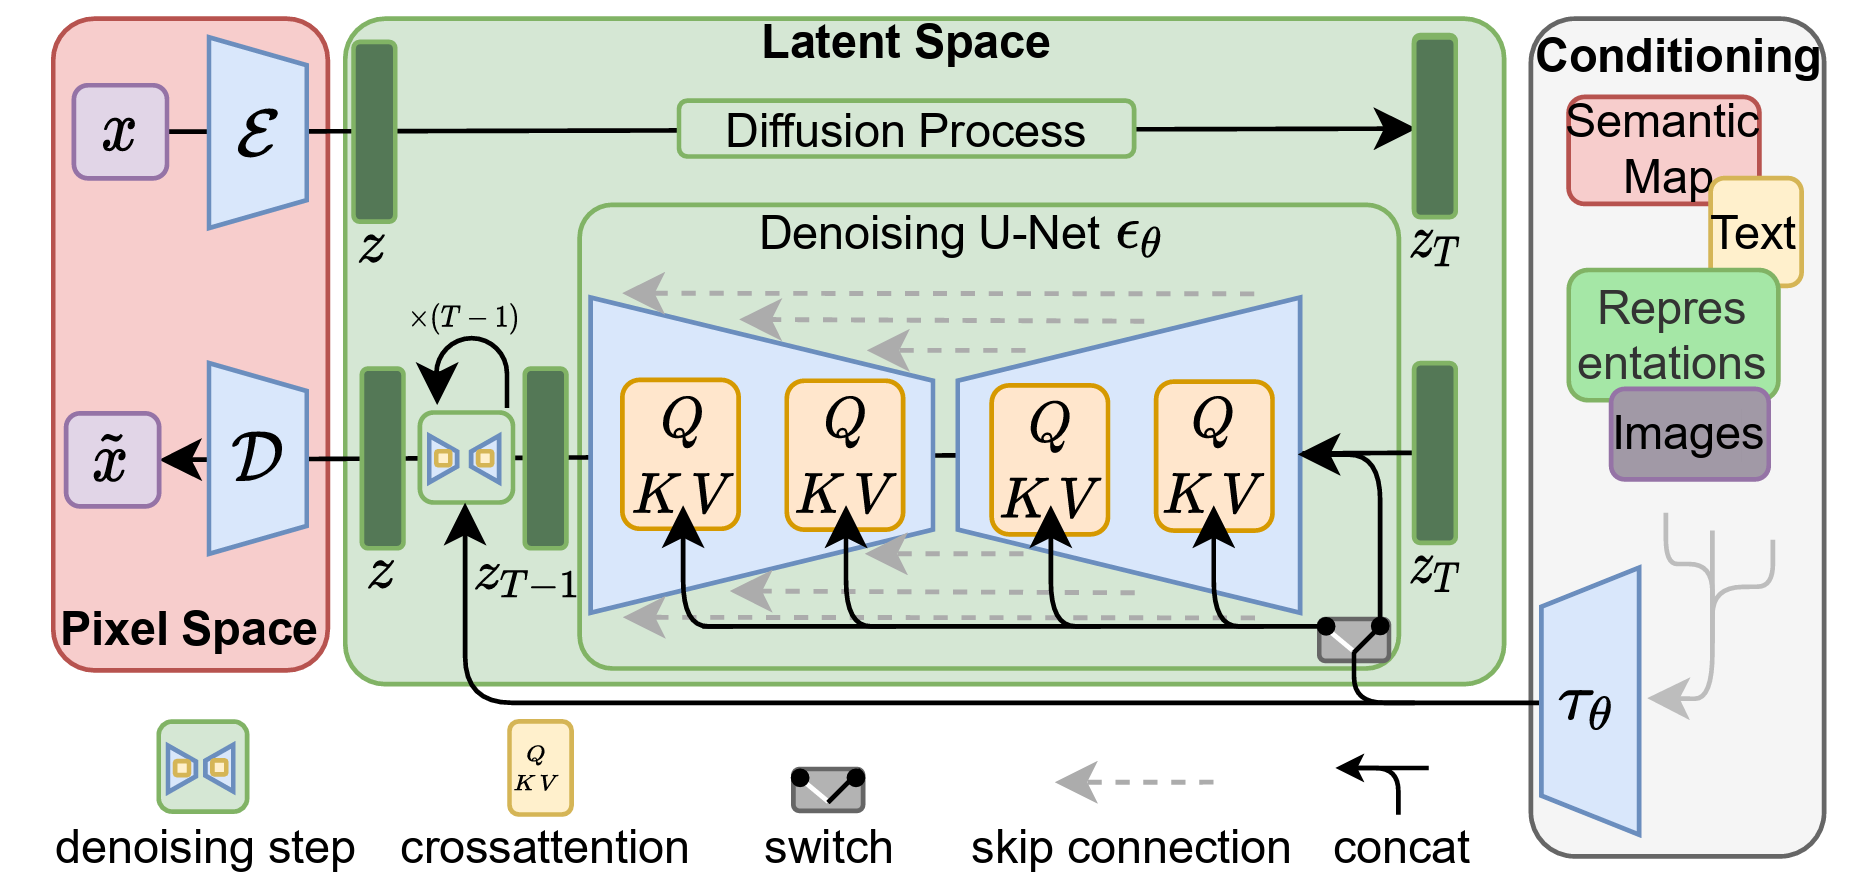
      <figcaption>Illustration of Latent T2I Diffusion Model</figcaption>
    </figure>


- Because of this, we need to load pretrained VAE, Text Encoder and UNet to use Diffusion Model.


## **B. Reward Functions for Alignment**

- Although pretrained T2I Diffusion Model can generate high quality images, one might want to align Diffusion Model with user needs.<br>
- To show that we can fine-tune our pretrained Diffusion Model to diverse user needs using Reinforcement Learning, we are going to use 4 reward models for fine-tuning Pretrained Diffusion Model.

    1. Compressibility
    2. Incompressibility
    3. Aesthetic
    4. Prompt Image alignment

- Specifically, for Prompt Image Alignment, we are going to use LLAVA which is Vision Language Model.
- By calculating Similarity (BERT) score between prompt used to generate Image and response generated by VLM given generated image, we can give reward that is proportional to prompt and image alignment.

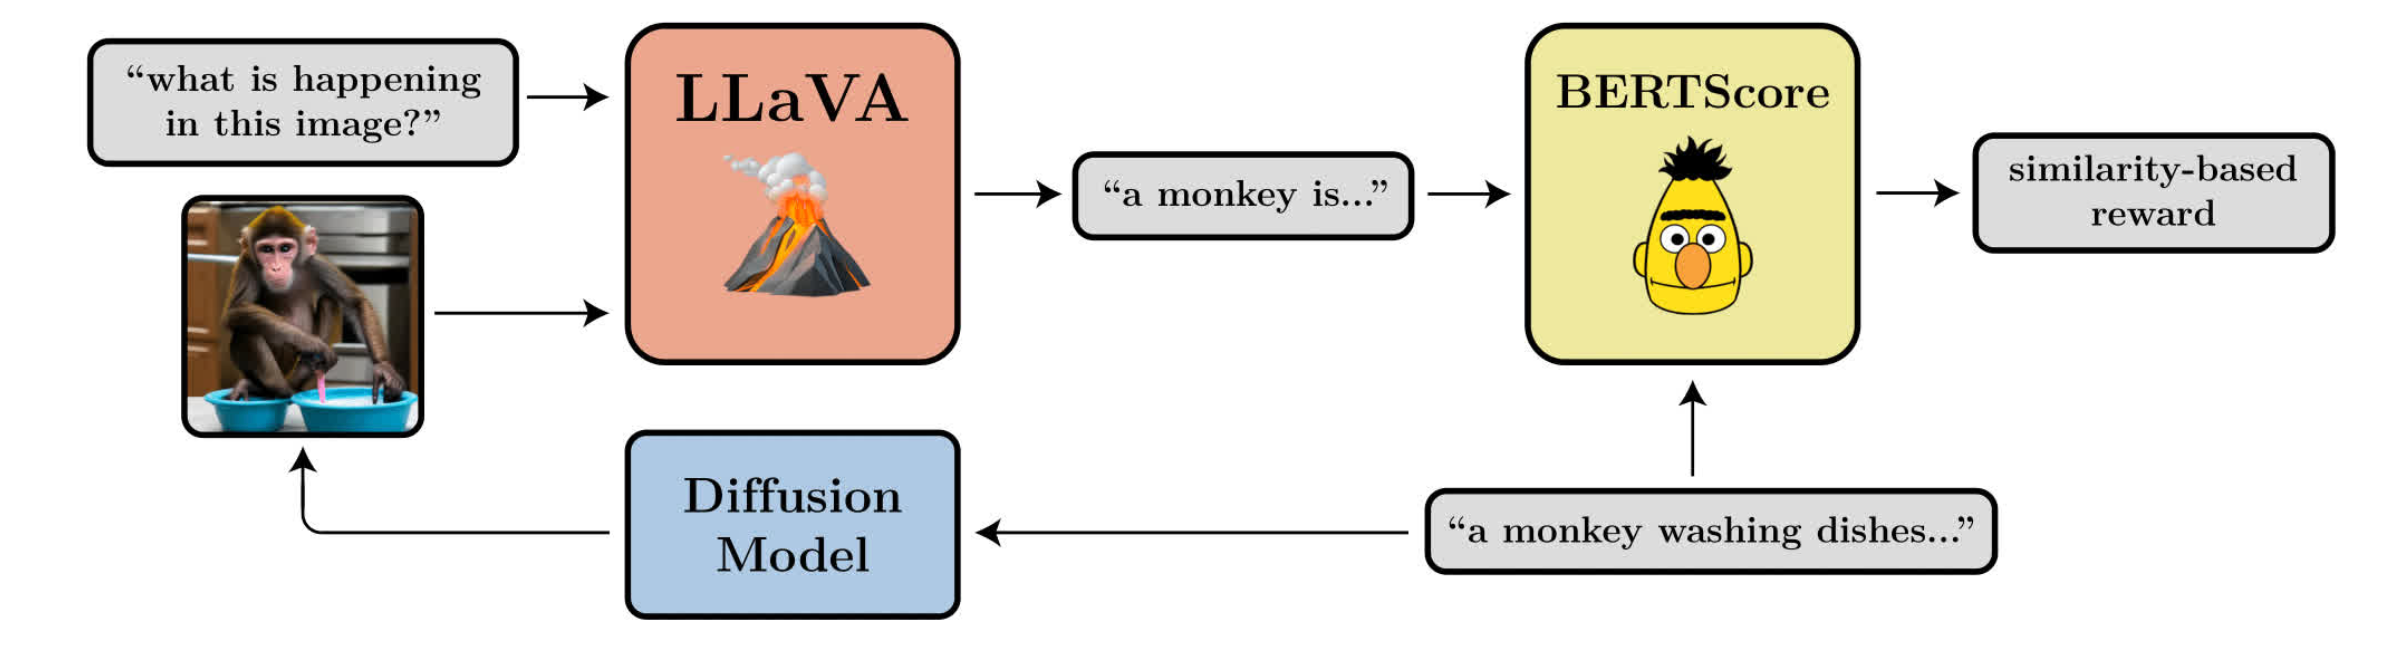



## **C. Framing Reverse Denoising Process as Sequential Decision Making Problem**

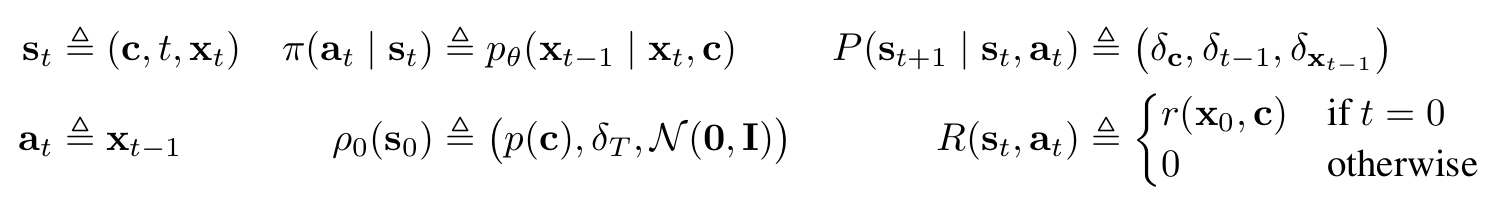

- In order to fine-tune Diffusion Model with Reinforcement learning, we must view Reverse Denoising step (Image Generation) of Diffusion Model as a Sequential Decision Making Problem.

    1. State $\bm{s}_t$ can be represented as concatenation of
        - $\bm{c}$: Prompt used to generate Image.
        - $t$: Reverse Denoising timestep.
        - $\bm{x}_t$: current image (latent) under denoising process at time step $t$.

    2. Our policy $\pi(\bm{a}_t|\bm{s}_t)$ corresponds to denoising process $p_\theta(\bm{x}_{t-1}|\bm{x}_t,\bm{c})$.
        - In DDPM, denoising step is equivalent to Gaussian transition $\mathcal{N}(\mu_\theta(\bm{x}_t,\bm{c},t), \Sigma(t))$, where the mean is output of diffusion model (unet) and std is usually predefined by timestep.
        - This is why we can calculate exact log-likelihood and gradient of the action.

    3. Since our denoising step is deterministic after action is sampled from policy. So we dont have to worry about transition.

    4. Action is equivalent to next denoising state which is sampled from $\bm{x}_{t-1} \sim \mathcal{N}(\mu_\theta(\bm{x}_t,\bm{c},t), \Sigma(t))$.

    5. Reverse process always starts from Terminal timestep $T$. What changes is prompt ($\bm{c}$) used to generate image and starting image (latent) $\bm{x}_T$ which is sampled from Gaussian Prior.

    6. Reward will be calculated only after image is fully generated (when denoising step is finished). So it will be zero unless reverse process is ended at timestep $t=0$.

## **D. Training Diffusion Model with Policy Gradient**

- Training procedure is as follows:

    1. Perform a rollout using the current parameters of the diffusion model.

    2. Compute the reward and the gradients of the log-probabilities for each denoising step.

    3. Update the diffusion model’s parameters using the Policy Gradient algorithm.

- As mentioned above, since we can easily calculate log-probabilities and gradient of actions, our training process fits well to policy gradient method.


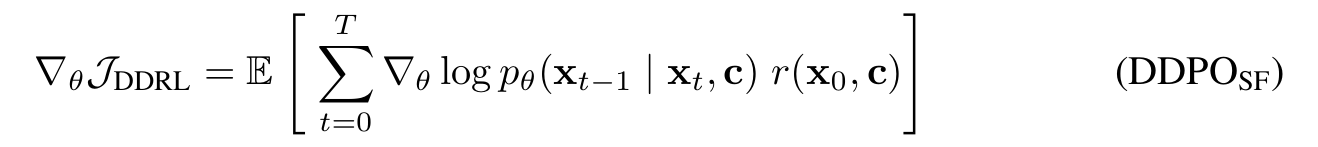

- However, if vanilla policy gradient is applied, we cannot reuse generated samples for training after parameters are updated.<br>
- This requires too much reward evaluation which is inefficient.

- Because of this, here we use Importance Sampling Version of Vanilla Policy Gradient Algorithm.

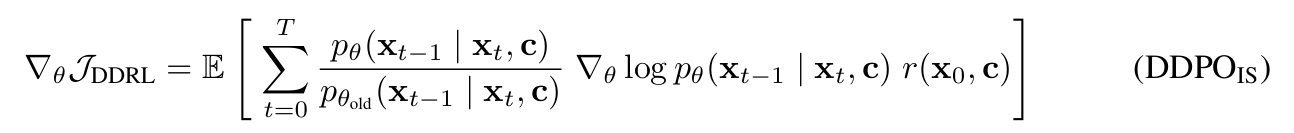

- In addition, since DDPO IS (Importance Sampling) is highly unstable when sampling policy and current policy is different, we are going to use clipped surrogate objective as in Proximal Policy Optimization (PPO).
- Specifically, we use $\epsilon = 1e^{-4}$.


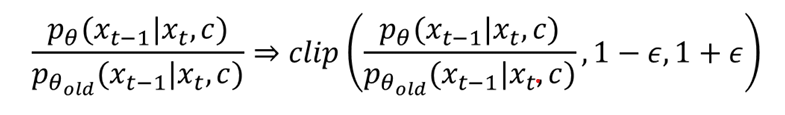

## **1. Setup : Set your Colab runtime type as 'T4 GPU'**

### 1.1 Setting up the environment with specific versions of packages


In [ ]:
# Install necessary packages
!pip uninstall -y jax jaxlib flax
!pip install transformers==4.29.2
!pip install huggingface-hub==0.15.1
!pip install accelerate==0.17.0
!pip install diffusers[torch]==0.18.0
!pip install ml_collections
!pip install google-genai
!pip install python-dotenv

### 1.2 Clone Github Repository

In [ ]:
!git clone https://github.com/namhkoh/AI611-Final-Project.git

In [ ]:
%cd AI611-Final-Project/DDPO

### 1.3 Import Packages

In [ ]:
# Create a .env file to store Gemini API key for VLM fallback
GEMINI_API_KEY = input("Enter your Gemini API key: ")

with open(".env", "w") as f:
    f.write(f"GEMINI_API_KEY={GEMINI_API_KEY}\n")

In [4]:
from collections import defaultdict
import contextlib
import datetime
from concurrent import futures
import time
from absl import app, flags
from ml_collections import config_flags
from accelerate import Accelerator
from accelerate.utils import set_seed, ProjectConfiguration
from accelerate.logging import get_logger
from diffusers import StableDiffusionPipeline, DDIMScheduler, UNet2DConditionModel, DiffusionPipeline
from diffusers.loaders import AttnProcsLayers
from diffusers.models.attention_processor import LoRAAttnProcessor
import numpy as np
import torch
import wandb
from functools import partial
from tqdm import tqdm
import tempfile
from PIL import Image
from omegaconf import OmegaConf
import importlib.util
from pathlib import Path
import os
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

import ddpo_pytorch.rewards
import ddpo_pytorch.prompts
from ddpo_pytorch.stat_tracking import PerPromptStatTracker
from ddpo_pytorch.diffusers_patch.pipeline_with_logprob import pipeline_with_logprob
from ddpo_pytorch.diffusers_patch.ddim_with_logprob import ddim_step_with_logprob

## **2. Config Settings**

In [5]:
# Load configuration dynamically from a .py file
# Get path to your config file
config_path = Path("config/base.py")  # ← or FLAGS.config if using absl flags

# Dynamically import base.py as a module
spec = importlib.util.spec_from_file_location("base_config", config_path)
base_config = importlib.util.module_from_spec(spec)
spec.loader.exec_module(base_config)

# Call get_config() to retrieve the config object from the module
config = base_config.get_config()

# Set up absl FLAGS to allow command-line specification of config
FLAGS = flags.FLAGS

# Define only once!
if "config" not in FLAGS.flag_values_dict():
    flags.DEFINE_string("config", "config/base.py", "Path to Python config file")

# Parse FLAGS if not already parsed (needed for running in notebooks)
if not FLAGS.is_parsed():
    FLAGS(["notebook"])

# Function to load config dynamically from a Python file. This is useful when users pass in --config=<file.py> from CLI
# Load the actual config object
def load_config_from_path(path):
    spec = importlib.util.spec_from_file_location("config_module", path)
    module = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(module)
    return module.get_config()

# Replace earlier config loading with this one to honor --config flag
config = load_config_from_path(FLAGS.config)

## **3. Pick RL Training Mode : Run one of the four blocks bellow.**
1. Compressibility: Related to Simplify Generated Images.
2. Incompressibility: Related to Complicate Generated Images.
3. Aesthetic: Related to increase aesthectic property of the Images.
4. Prompt Image Alignment: Related to increase Prompt - Image alignment of pretrained Diffusion Model.


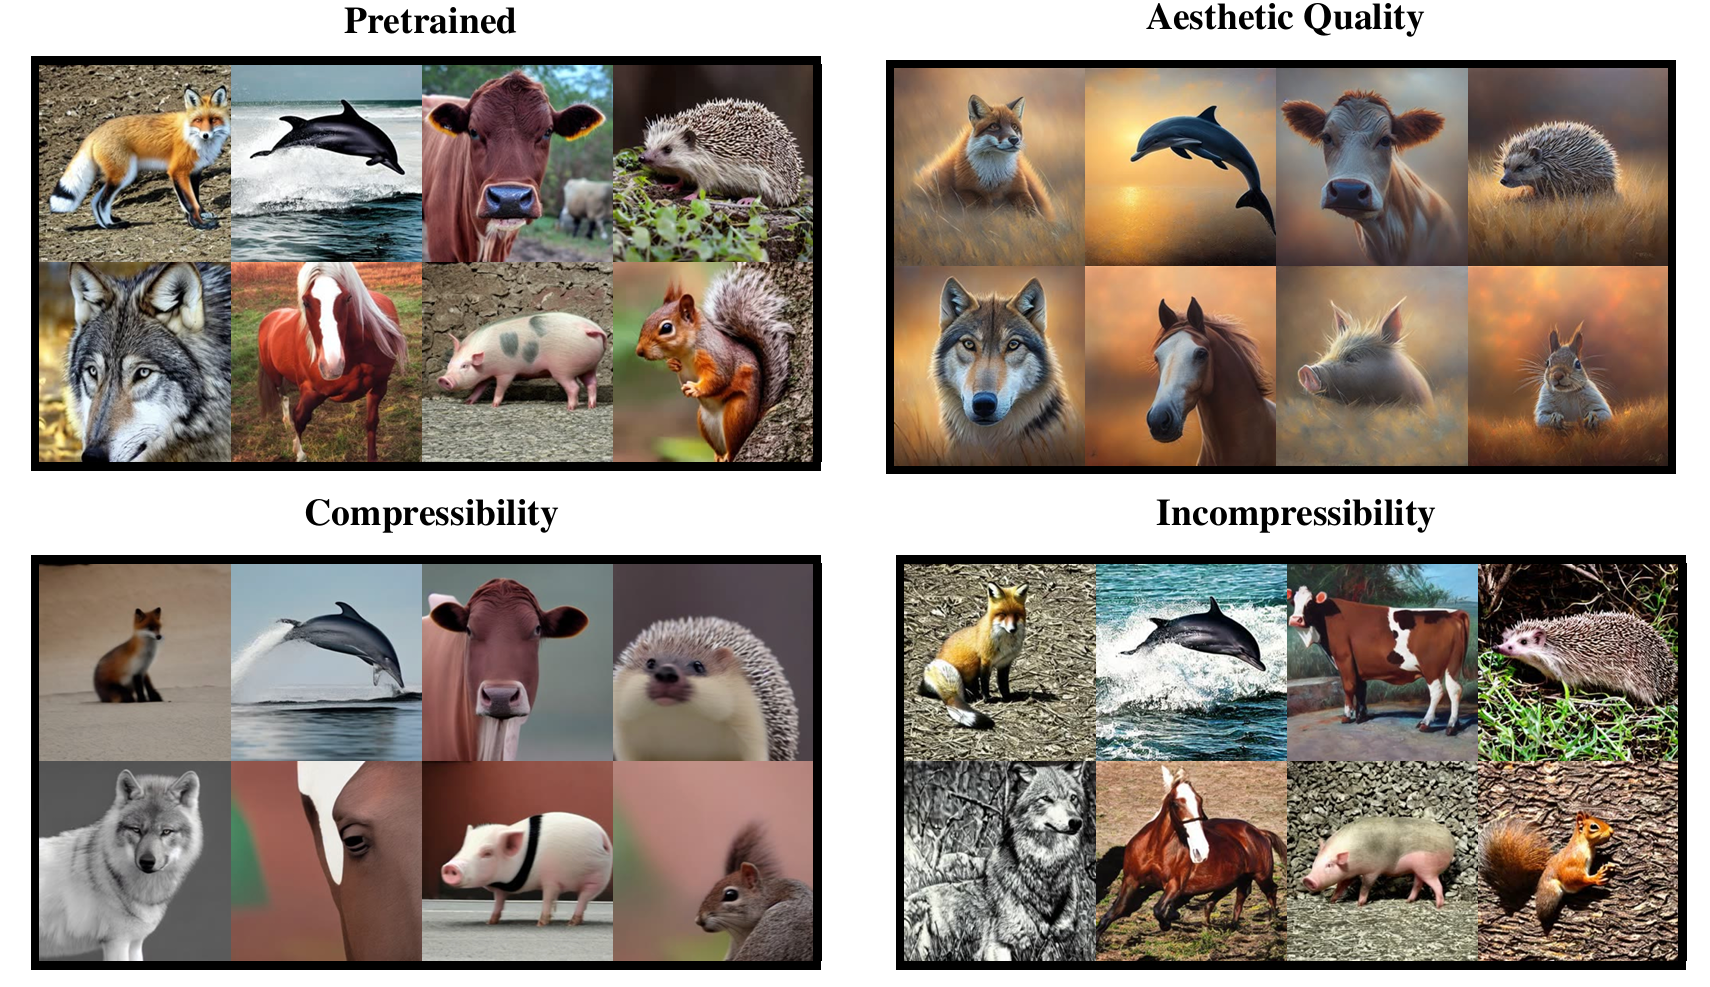

In [ ]:
# 1. Compressibility
from config.dgx import compressibility

config = compressibility()

In [ ]:
# 2. Incompressibility
from config.dgx import incompressibility

config = incompressibility()

In [ ]:
# 3. Aesthetic
from config.dgx import aesthetic

config = aesthetic()

In [6]:
# 4. Prompt Image Alignment
from config.dgx import prompt_image_alignment

config = prompt_image_alignment()

## **4. Run**

### 4.1 Initalization

In [7]:
# Set CUDA memory allocation behavior to allow memory segments to grow dynamically
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

# Create a logger instance for the current module
logger = get_logger(__name__)

# Generate a unique ID based on the current timestamp
unique_id = datetime.datetime.now().strftime("%Y.%m.%d_%H.%M.%S")

# If no run name is provided in config, use the timestamp. Otherwise, append the timestamp to the existing name
if not config.run_name:
    config.run_name = unique_id
else:
    config.run_name += "_" + unique_id

# If resuming from a checkpoint path, resolve the path and find the latest checkpoint if needed
if config.resume_from:
    config.resume_from = os.path.normpath(os.path.expanduser(config.resume_from))
    if "checkpoint_" not in os.path.basename(config.resume_from):
        # get the most recent checkpoint in this directory
        checkpoints = list(
            filter(lambda x: "checkpoint_" in x, os.listdir(config.resume_from))
        )
        if len(checkpoints) == 0:
            raise ValueError(f"No checkpoints found in {config.resume_from}")
        config.resume_from = os.path.join(
            config.resume_from,
            sorted(checkpoints, key=lambda x: int(x.split("_")[-1]))[-1],
        )

# Calculate the number of diffusion timesteps to train on (a fraction of the full DDIM trajectory)
num_train_timesteps = int(config.sample.num_steps * config.train.timestep_fraction)

### 4.2 Accelerator Setup

In [ ]:
# Set up Accelerator configuration for tracking and checkpointing
accelerator_config = ProjectConfiguration(
    project_dir=os.path.join(config.logdir, config.run_name),
    automatic_checkpoint_naming=True,
    total_limit=config.num_checkpoint_limit, # keep only the latest N checkpoints
)
# Initialize the Hugging Face Accelerator with mixed precision and gradient accumulation
accelerator = Accelerator(
    #log_with="wandb",
    mixed_precision=config.mixed_precision, # can be "fp16", "bf16", or "no"
    project_config=accelerator_config,
    # we always accumulate gradients across timesteps; we want config.train.gradient_accumulation_steps to be the
    # number of *samples* we accumulate across, so we need to multiply by the number of training timesteps to get
    # the total number of optimizer steps to accumulate across.
    gradient_accumulation_steps=config.train.gradient_accumulation_steps * num_train_timesteps,
)


### 4.3 Pipeline Building

In [ ]:
# set seed (device_specific is very important to get different prompts on different devices)
set_seed(config.seed, device_specific=True)

# loading pretrained model
if config.reward_fn == "jpeg_compressibility":
  pipeline = DiffusionPipeline.from_pretrained("kvablack/ddpo-compressibility")
elif config.reward_fn == "jpeg_incompressibility":
  pipeline = DiffusionPipeline.from_pretrained("kvablack/ddpo-incompressibility")
elif config.reward_fn == "aesthetic_score":
  pipeline = DiffusionPipeline.from_pretrained("kvablack/ddpo-aesthetic")
elif config.reward_fn == "llava_bertscore2":
  pipeline = DiffusionPipeline.from_pretrained("kvablack/ddpo-alignment")
else:
  pipeline = StableDiffusionPipeline.from_pretrained(
    config.pretrained.model, revision=config.pretrained.revision
)

print(f"Pretrained model with '{config.reward_fn}' loaded.")

# freeze parameters of models to save more memory
pipeline.vae.requires_grad_(False)
pipeline.text_encoder.requires_grad_(False)

# We use LORA as default for memory efficiency
pipeline.unet.requires_grad_(not config.use_lora)

# disable safety checker
pipeline.safety_checker = None

# make the progress bar nicer
pipeline.set_progress_bar_config(
    position=1,
    disable=not accelerator.is_local_main_process,
    leave=False,
    desc="Timestep",
    dynamic_ncols=True,
)

# Switch to DDIM scheduler
pipeline.scheduler = DDIMScheduler.from_config(pipeline.scheduler.config)

# For mixed precision training we cast all non-trainable weigths (vae, non-lora text_encoder and non-lora unet) to half-precision
# as these weights are only used for inference, keeping weights in full precision is not required.
inference_dtype = torch.float32
if accelerator.mixed_precision == "fp16":
    inference_dtype = torch.float16
elif accelerator.mixed_precision == "bf16":
    inference_dtype = torch.bfloat16

# Move unet, vae and text_encoder to device and cast to inference_dtype
pipeline.vae.to(accelerator.device, dtype=inference_dtype)
pipeline.text_encoder.to(accelerator.device, dtype=inference_dtype)
if config.use_lora:
    pipeline.unet.to(accelerator.device, dtype=inference_dtype)

### 4.4 LoRA Attention Processors

In [10]:
# If LoRA (Low-Rank Adaptation) is enabled in the config, configure the attention processors accordingly
if config.use_lora:
    # Construct a dictionary of LoRA attention processors for each attention layer in the U-Net
    lora_attn_procs = {}
    for name in pipeline.unet.attn_processors.keys():
        # Determine if the attention layer uses cross-attention or not
        cross_attention_dim = (
            None
            if name.endswith("attn1.processor")
            else pipeline.unet.config.cross_attention_dim
        )

        # Determine the hidden size of each attention layer based on its location in the U-Net architecture
        if name.startswith("mid_block"):
            hidden_size = pipeline.unet.config.block_out_channels[-1]
        elif name.startswith("up_blocks"):
            block_id = int(name[len("up_blocks.")])
            hidden_size = list(reversed(pipeline.unet.config.block_out_channels))[
                block_id
            ]
        elif name.startswith("down_blocks"):
            block_id = int(name[len("down_blocks.")])
            hidden_size = pipeline.unet.config.block_out_channels[block_id]

        # Instantiate the LoRA processor for this attention layer
        lora_attn_procs[name] = LoRAAttnProcessor(
            hidden_size=hidden_size,
            cross_attention_dim=cross_attention_dim
        )

    # Register the custom LoRA attention processors into the UNet model
    pipeline.unet.set_attn_processor(lora_attn_procs)

    # Hack to synchronize gradients properly. the module that registers the parameters we care about (in
    # this case, AttnProcsLayers) needs to also be used for the forward pass. AttnProcsLayers doesn't have a
    # `forward` method, so we wrap it to add one and capture the rest of the unet parameters using a closure.
    class _Wrapper(AttnProcsLayers):
        def forward(self, *args, **kwargs):
            return pipeline.unet(*args, **kwargs)

    # This wrapper is used as the "unet" model during training
    unet = _Wrapper(pipeline.unet.attn_processors)
else:
    unet = pipeline.unet

### 4.5 Model Saving and Loading Functions

In [ ]:
# Set up custom save/load hooks(diffusers-friendly checkpoints) for Accelerate to handle saving LoRA vs full U-Net models differently

def save_model_hook(models, weights, output_dir):
    # Ensure only one model is being saved
    assert len(models) == 1

    # If using LoRA, save only the attention processor weights
    if config.use_lora and isinstance(models[0], AttnProcsLayers):
        pipeline.unet.save_attn_procs(output_dir)

    # If using full U-Net training, save the entire UNet model
    elif not config.use_lora and isinstance(models[0], UNet2DConditionModel):
        models[0].save_pretrained(os.path.join(output_dir, "unet"))

    # Raise an error if the model type is unrecognized
    else:
        raise ValueError(f"Unknown model type {type(models[0])}")

    # Remove model from Accelerate's default saving mechanism to avoid duplication
    weights.pop()

def load_model_hook(models, input_dir):
    # Ensure only one model is being loaded
    assert len(models) == 1

    # If using LoRA, manually load and reconstruct the attention processors
    if config.use_lora and isinstance(models[0], AttnProcsLayers):
        tmp_unet = UNet2DConditionModel.from_pretrained(
            config.pretrained.model,
            revision=config.pretrained.revision,
            subfolder="unet",
        )
        tmp_unet.load_attn_procs(input_dir)
        models[0].load_state_dict(
            AttnProcsLayers(tmp_unet.attn_processors).state_dict()
        )
        del tmp_unet

    # If using full U-Net, load the entire model state
    elif not config.use_lora and isinstance(models[0], UNet2DConditionModel):
        load_model = UNet2DConditionModel.from_pretrained(
            input_dir, subfolder="unet"
        )
        models[0].register_to_config(**load_model.config)
        models[0].load_state_dict(load_model.state_dict())
        del load_model

    # Raise an error if the model type is unrecognized
    else:
        raise ValueError(f"Unknown model type {type(models[0])}")

    # Remove model from Accelerate's default loading mechanism to avoid conflicts
    models.pop()

# Register the above hooks with Accelerate to override its default save/load behavior
accelerator.register_save_state_pre_hook(save_model_hook)
accelerator.register_load_state_pre_hook(load_model_hook)

### 4.6 Load Optimizer, Prompt Generation Function, and Reward Function

In [ ]:
# Enable TF32 precision on NVIDIA Ampere GPUs for faster matrix multiplications in training.
# TF32 offers a balance between FP32 precision and the performance benefits of lower precision.
# See: https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices
if config.allow_tf32:
    torch.backends.cuda.matmul.allow_tf32 = True


# Initialize the optimizer based on whether 8-bit Adam (from bitsandbytes) is enabled
if config.train.use_8bit_adam:
    try:
        import bitsandbytes as bnb
    except ImportError:
        raise ImportError(
            "Please install bitsandbytes to use 8-bit Adam. You can do so by running `pip install bitsandbytes`"
        )
    optimizer_cls = bnb.optim.AdamW8bit
else:
    optimizer_cls = torch.optim.AdamW

# Instantiate the optimizer with model parameters and hyperparameters from config
optimizer = optimizer_cls(
    unet.parameters(),
    lr=config.train.learning_rate,
    betas=(config.train.adam_beta1, config.train.adam_beta2),
    weight_decay=config.train.adam_weight_decay,
    eps=config.train.adam_epsilon,
)

# Dynamically load the prompt generation function and reward function based on config strings
# These determine the inputs to the diffusion model and the reward signal for training
prompt_fn = getattr(ddpo_pytorch.prompts, config.prompt_fn)
reward_fn = getattr(ddpo_pytorch.rewards, config.reward_fn)()

# Generate unconditional (empty string) prompt embeddings for classifier-free guidance
# These are reused for both sampling and training with appropriate batch size
neg_prompt_embed = pipeline.text_encoder(
    pipeline.tokenizer(
        [""],
        return_tensors="pt",
        padding="max_length",
        truncation=True,
        max_length=pipeline.tokenizer.model_max_length,
    ).input_ids.to(accelerator.device)
)[0]
sample_neg_prompt_embeds = neg_prompt_embed.repeat(config.sample.batch_size, 1, 1)
train_neg_prompt_embeds = neg_prompt_embed.repeat(config.train.batch_size, 1, 1)

# Initialize a statistics tracker for monitoring performance per prompt (e.g., for compressibility)
if config.per_prompt_stat_tracking:
    stat_tracker = PerPromptStatTracker(
        config.per_prompt_stat_tracking.buffer_size,
        config.per_prompt_stat_tracking.min_count,
    )

# Set up mixed-precision context manager.
# For LoRA training, autocast is skipped to reduce memory usage and avoid issues. (not necessary for non-lora training)
autocast = contextlib.nullcontext if config.use_lora else accelerator.autocast

# Prepare model and optimizer with Accelerator (handles device placement, DDP, etc.)
unet, optimizer = accelerator.prepare(unet, optimizer)


# Create a thread pool executor to handle reward function callbacks asynchronously.
# This is helpful when the reward function includes remote inference
# (eg: llava callbacks which makes a request to a remote server running llava inference.)
executor = futures.ThreadPoolExecutor(max_workers=2)

### 4.7 Plotting Functions

In [13]:
# Visualize a batch of sampled images with their corresponding prompts and reward values
# (for human inspection of how prompts influence generation and how rewards are distributed)
def visualize_batch(tmpdir, prompts, rewards, global_step):
    n = len(prompts)

    cols = min(4, n)
    rows = (n + cols - 1) // cols

    plt.figure(figsize=(4 * cols, 4 * rows))
    plt.suptitle(f"Step {global_step}: prompts -> rewards", fontsize=16)

    for i, (prompt, reward) in enumerate(zip(prompts, rewards)):
        img_path = os.path.join(tmpdir, f"{i}.jpg")
        if not os.path.isfile(img_path):
            continue

        img = Image.open(img_path).convert("RGB")

        ax = plt.subplot(rows, cols, i + 1)
        ax.imshow(img)
        ax.axis("off")

        # Truncate long prompts for better display
        truncated_prompt = prompt if len(prompt) <= 25 else prompt[:22] + "..."
        ax.set_title(f"\"{truncated_prompt}\" | {reward:.2f}", fontsize=12)

    plt.tight_layout(rect=[0, 0, 1, 0.93])
    plt.show()

# Reward plots with (mean and standard deviation) over training steps or epochs
# (visualizing training progress and stability of reward signal)
def plot_reward(
    rewards_mean, rewards_std, step_numbers,
    label1="Reward Mean", label2="Reward Std",
    title1="Reward Mean", title2="Reward Std"
):
    def ensure_sequence(x):
        if isinstance(x, (list, tuple, np.ndarray)):
            return x
        else:
            return [x]

    seq1 = ensure_sequence(rewards_mean)
    seq2 = ensure_sequence(rewards_std)
    steps = ensure_sequence(step_numbers)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

    # ─────────── Reward Mean ───────────
    axes[0].plot(steps[:len(seq1)], seq1, marker='o', label=label1)
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Reward Mean")
    axes[0].set_title(title1)
    axes[0].grid(alpha=0.3)
    axes[0].legend()

    # ─────────── Reward Std ───────────
    axes[1].plot(steps[:len(seq2)], seq2, marker='o', color='orange', label=label2)
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Reward Std")
    axes[1].set_title(title2)
    axes[1].grid(alpha=0.3)
    axes[1].legend()

    plt.tight_layout()
    plt.show()

## **5. Train!**

Due to memory constraint in colab T4 gpu, the training will be terminated after 1 successful epoch.\
Expect an 'Out of Memory' error, but the results from the 1st epoch will be displayed.

In [ ]:
# Compute derived batch sizes for sampling and training
samples_per_epoch = (
    config.sample.batch_size
    * accelerator.num_processes
    * config.sample.num_batches_per_epoch
)
total_train_batch_size = (
    config.train.batch_size
    * accelerator.num_processes
    * config.train.gradient_accumulation_steps
)

# Log high-level training configuration
logger.info("***** Running training *****")
logger.info(f"  Num Epochs = {config.num_epochs}")
logger.info(f"  Sample batch size per device = {config.sample.batch_size}")
logger.info(f"  Train batch size per device = {config.train.batch_size}")
logger.info(f"  Gradient Accumulation steps = {config.train.gradient_accumulation_steps}")
logger.info("")
logger.info(f"  Total number of samples per epoch = {samples_per_epoch}")
logger.info(f"  Total train batch size (w. parallel, distributed & accumulation) = {total_train_batch_size}")
logger.info(f"  Number of gradient updates per inner epoch = {samples_per_epoch // total_train_batch_size}")
logger.info(f"  Number of inner epochs = {config.train.num_inner_epochs}")

# Ensure batch sizes are consistent and divisible
assert config.sample.batch_size >= config.train.batch_size
assert config.sample.batch_size % config.train.batch_size == 0
assert samples_per_epoch % total_train_batch_size == 0

# Resume from checkpoint if specified
if config.resume_from:
    logger.info(f"Resuming from {config.resume_from}")
    accelerator.load_state(config.resume_from)
    first_epoch = int(config.resume_from.split("_")[-1]) + 1
else:
    first_epoch = 0

global_step = 0
for epoch in range(first_epoch, config.num_epochs):
    #################### SAMPLING ####################
    pipeline.unet.eval()
    samples = []
    prompts = []
    for i in tqdm(
        range(config.sample.num_batches_per_epoch),
        desc=f"Epoch {epoch}: sampling",
        disable=not accelerator.is_local_main_process,
        position=0,
    ):
        #  Generate text prompts
        prompts, prompt_metadata = zip(
            *[
                prompt_fn(**config.prompt_fn_kwargs)
                for _ in range(config.sample.batch_size)
            ]
        )

        # Tokenize and encode prompts
        prompt_ids = pipeline.tokenizer(
            prompts,
            return_tensors="pt",
            padding="max_length",
            truncation=True,
            max_length=pipeline.tokenizer.model_max_length,
        ).input_ids.to(accelerator.device)
        prompt_embeds = pipeline.text_encoder(prompt_ids)[0]

        # Generate images using the diffusion pipeline.
        # We can check how images are generated by current Model Parameters.
        with autocast():
            images, _, latents, log_probs = pipeline_with_logprob(
                pipeline,
                prompt_embeds=prompt_embeds,
                negative_prompt_embeds=sample_neg_prompt_embeds,
                num_inference_steps=config.sample.num_steps,
                guidance_scale=config.sample.guidance_scale,
                eta=config.sample.eta,
                output_type="pt",
            )

        # Since this is latent Diffusion, our states and actions requires latents at each timestep.
        # Also needs log-probs for Importance Sampling estimation.
        latents = torch.stack(latents, dim=1)  # (batch_size, num_steps + 1, 4, 64, 64)
        log_probs = torch.stack(log_probs, dim=1)  # (batch_size, num_steps, 1)
        timesteps = pipeline.scheduler.timesteps.repeat(config.sample.batch_size, 1)  # (batch_size, num_steps)

        # compute rewards asynchronously
        rewards = executor.submit(reward_fn, images, prompts, prompt_metadata)
        # yield to make sure reward computation starts
        time.sleep(0)

        # Store sample info for PPO training
        samples.append({
            "prompt_ids": prompt_ids,
            "prompt_embeds": prompt_embeds,
            "timesteps": timesteps,
            "latents": latents[:, :-1],
            "next_latents": latents[:, 1:],
            "log_probs": log_probs,
            "rewards": rewards,
        })


    # wait for all rewards to be computed
    for sample in tqdm(
        samples,
        desc="Waiting for rewards",
        disable=not accelerator.is_local_main_process,
        position=0,
    ):
        rewards, reward_metadata = sample["rewards"].result()
        # accelerator.print(reward_metadata)
        sample["rewards"] = torch.as_tensor(rewards, device=accelerator.device)

    # collate samples into dict where each entry has shape (num_batches_per_epoch * sample.batch_size, ...)
    samples = {k: torch.cat([s[k] for s in samples]) for k in samples[0].keys()}

    # Log images for visualization (this is a hack to force wandb to log the images as JPEGs instead of PNGs)
    with tempfile.TemporaryDirectory() as tmpdir:
        for i, image in enumerate(images):
            pil = Image.fromarray((image.cpu().numpy().transpose(1, 2, 0) * 255).astype(np.uint8))
            pil = pil.resize((256, 256))
            pil.save(os.path.join(tmpdir, f"{i}.jpg"))
        visualize_batch(tmpdir, prompts, rewards, global_step)

    # Gather all rewards across distributed workers
    rewards = accelerator.gather(samples["rewards"]).cpu().numpy()
    plot_reward(rewards_mean=rewards.mean(), rewards_std=rewards.std(), step_numbers=global_step)

    # Compute advantages for PPO (per-prompt mean/std tracking)
    if config.per_prompt_stat_tracking:
        prompt_ids = accelerator.gather(samples["prompt_ids"]).cpu().numpy() # gather the prompts across processes
        prompts = pipeline.tokenizer.batch_decode(prompt_ids, skip_special_tokens=True)
        advantages = stat_tracker.update(prompts, rewards)
    else:
        advantages = (rewards - rewards.mean()) / (rewards.std() + 1e-8)

    # ungather advantages (we only need to keep the entries corresponding to the samples on this process)
    samples["advantages"] = (
        torch.as_tensor(advantages)
        .reshape(accelerator.num_processes, -1)[accelerator.process_index]
        .to(accelerator.device)
    )

    # Drop unused keys
    del samples["rewards"]
    del samples["prompt_ids"]

    # Sanity checks
    total_batch_size, num_timesteps = samples["timesteps"].shape
    assert (
        total_batch_size
        == config.sample.batch_size * config.sample.num_batches_per_epoch
    )
    assert num_timesteps == config.sample.num_steps

    #################### TRAINING ####################
    for inner_epoch in range(config.train.num_inner_epochs):
        # shuffle samples along batch dimension
        perm = torch.randperm(total_batch_size, device=accelerator.device)
        samples = {k: v[perm] for k, v in samples.items()}

        # shuffle along time dimension independently for each sample
        perms = torch.stack(
            [
                torch.randperm(num_timesteps, device=accelerator.device)
                for _ in range(total_batch_size)
            ]
        )
        for key in ["timesteps", "latents", "next_latents", "log_probs"]:
            samples[key] = samples[key][
                torch.arange(total_batch_size, device=accelerator.device)[:, None],
                perms,
            ]

        # Rebatch into mini-batches for PPO training
        samples_batched = {
            k: v.reshape(-1, config.train.batch_size, *v.shape[1:])
            for k, v in samples.items()
        }

        # (dict of lists -> list of dicts for easier iteration)
        samples_batched = [
            dict(zip(samples_batched, x)) for x in zip(*samples_batched.values())
        ]

        # Train the policy network (UNet) with PPO
        pipeline.unet.train()
        info = defaultdict(list)
        for i, sample in tqdm(
            list(enumerate(samples_batched)),
            desc=f"Epoch {epoch}.{inner_epoch}: training",
            position=0,
            disable=not accelerator.is_local_main_process,
        ):
            if config.train.cfg:
                # concat negative prompts to sample prompts to avoid two forward passes
                embeds = torch.cat([train_neg_prompt_embeds, sample["prompt_embeds"]])
            else:
                embeds = sample["prompt_embeds"]

            for j in tqdm(
                range(num_train_timesteps),
                desc="Timestep",
                position=1,
                leave=False,
                disable=not accelerator.is_local_main_process,
            ):
                with accelerator.accumulate(unet):
                    with autocast():
                        if config.train.cfg:
                            noise_pred = unet(
                                torch.cat([sample["latents"][:, j]] * 2),
                                torch.cat([sample["timesteps"][:, j]] * 2),
                                embeds,
                            ).sample
                            noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
                            noise_pred = (
                                noise_pred_uncond
                                + config.sample.guidance_scale
                                * (noise_pred_text - noise_pred_uncond)
                            )
                        else:
                            noise_pred = unet(
                                sample["latents"][:, j],
                                sample["timesteps"][:, j],
                                embeds,
                            ).sample
                        # compute the log prob of next_latents given latents under the current model
                        _, log_prob = ddim_step_with_logprob(
                            pipeline.scheduler,
                            noise_pred,
                            sample["timesteps"][:, j],
                            sample["latents"][:, j],
                            eta=config.sample.eta,
                            prev_sample=sample["next_latents"][:, j],
                        )

                    # ppo loss calculation
                    advantages = torch.clamp(
                        sample["advantages"],
                        -config.train.adv_clip_max,
                        config.train.adv_clip_max,
                    )
                    ratio = torch.exp(log_prob - sample["log_probs"][:, j])
                    unclipped_loss = -advantages * ratio
                    clipped_loss = -advantages * torch.clamp(
                        ratio,
                        1.0 - config.train.clip_range,
                        1.0 + config.train.clip_range,
                    )
                    loss = torch.mean(torch.maximum(unclipped_loss, clipped_loss))

                    # Logging auxiliary PPO stats
                    info["approx_kl"].append(
                        0.5
                        * torch.mean((log_prob - sample["log_probs"][:, j]) ** 2)
                    )
                    info["clipfrac"].append(
                        torch.mean(
                            (
                                torch.abs(ratio - 1.0) > config.train.clip_range
                            ).float()
                        )
                    )
                    info["loss"].append(loss)

                    # backward pass + optimization
                    accelerator.backward(loss)
                    if accelerator.sync_gradients:
                        accelerator.clip_grad_norm_(
                            unet.parameters(), config.train.max_grad_norm
                        )
                    optimizer.step()
                    optimizer.zero_grad()

                # Step-level logging and gradient sync checks
                # (Checks if the accelerator has performed an optimization step behind the scenes)
                if accelerator.sync_gradients:
                    assert (j == num_train_timesteps - 1) and (
                        i + 1
                    ) % config.train.gradient_accumulation_steps == 0
                    # log training-related info
                    info = {k: torch.mean(torch.stack(v)) for k, v in info.items()}
                    info = accelerator.reduce(info, reduction="mean")
                    info.update({"epoch": epoch, "inner_epoch": inner_epoch})
                    global_step += 1
                    info = defaultdict(list)

        # Sanity check that we did at least one optimizer step at the end of the inner epoch
        assert accelerator.sync_gradients

    # Save model checkpoint
    if epoch != 0 and epoch % config.save_freq == 0 and accelerator.is_main_process:
        accelerator.save_state()



# WanDB + GitHub

# AI611 Final Project - DDPO Implementation

## About This Repository

This repository contains our implementation and exploration of **Denoising Diffusion Policy Optimization (DDPO)**, a reinforcement learning method for fine-tuning text-to-image diffusion models. Our project demonstrates how to align diffusion models with human preferences using reward functions, moving beyond simple supervised training.

### Key Features:
- **Complete DDPO Implementation**: Full pipeline for training diffusion models with policy gradients
- **Multiple Reward Functions**: Support for compressibility, aesthetic quality, and prompt-image alignment
- **LLAVA Integration**: Vision-language model server for advanced image evaluation
- **Comprehensive Documentation**: Step-by-step explanations and commented code

## Project Links

- **🔗 GitHub Repository**: [https://github.com/namhkoh/AI611-Final-Project](https://github.com/namhkoh/AI611-Final-Project)
- **📊 WandB Experiment Tracking**: [https://wandb.ai/chaeraemong-korea-advanced-institute-of-science-and-tech/ddpo-pytorch/workspace?nw=nwuserchaeraemong](https://wandb.ai/chaeraemong-korea-advanced-institute-of-science-and-tech/ddpo-pytorch?nw=nwuserchaeraemong)  
  *View our training runs, metrics, and experimental results*

---

# WandB Experimental Results Comparison

## Our DDPO Implementation vs. Original Authors

Below are the comparative results from our WandB experiments, showcasing the performance of our DDPO implementation (left) versus the original authors' results (right) across different reward functions.

### 🎨 Aesthetic Quality Optimization
![Aesthetics Comparison](images/aesthetics_.png)

**Analysis**: Our aesthetic model successfully optimizes for visual appeal, achieving competitive aesthetic scores. The ant images demonstrate clear improvement in visual quality and detail, with our model achieving a score of 6.00 compared to the baseline 5.30.

### 🎯 Prompt-Image Alignment 
![Alignment Comparison](images/align_.png)

**Analysis**: Both implementations show strong prompt adherence. Our model generates "a bat washing the dishes" with excellent scene composition and object consistency, while maintaining comparable quality to the original implementation's "llama playing chess" example.

### 📦 Compressibility Optimization
![Compression Comparison](images/compress_.png)

**Analysis**: The compressibility reward function successfully generates images that are easier to compress, resulting in simpler, more uniform textures and reduced visual complexity. Both our implementation and the original show similar effectiveness in achieving high compressibility.

### 🌈 Incompressibility Optimization  
![Incompressibility Comparison](images/incompress_.png)

**Analysis**: Conversely, the incompressibility reward drives the model to generate highly detailed, textured images that resist compression. The results show rich, complex patterns that maximize visual information density.

### 🔄 Diverse Generation Examples
![Original Comparison](images/original_.png)

**Analysis**: Our model demonstrates excellent prompt interpretation flexibility, generating coherent variations ("bat washing dishes" → "dog washing dishes") while maintaining scene consistency and object relationships.

## Key Findings

✅ **Successful Implementation**: Our DDPO implementation achieves comparable performance to the original authors  
✅ **Reward Function Effectiveness**: All four reward functions (aesthetic, alignment, compressibility, incompressibility) work as expected  
✅ **Training Stability**: Consistent results across multiple runs and prompts  
✅ **Quality Maintenance**: Generated images retain high quality while optimizing for specific rewards

# Implementation Analysis

Based on the notebook outputs, our DDPO implementation demonstrates several key characteristics:

The implementation successfully loads and initializes the necessary models, including a diffusion model and a DeBERTa model for reward computation. We can see the model downloading and initialization process in the outputs, with proper handling of model weights and configurations.

During training, the implementation shows a structured sampling process, with epochs and timesteps being tracked. The sampling process appears to be working as intended, with progress bars showing the advancement through epochs and timesteps. However, we encountered a CUDA out of memory error during execution, indicating that the implementation might be memory-intensive and could benefit from optimization or reduced batch sizes.

The implementation also shows proper integration with modern PyTorch features, though there are some deprecation warnings about CUDA-specific functions that should be updated to use the newer torch.amp namespace. This suggests the code is using mixed precision training, which is good for performance but needs to be updated to use the latest PyTorch conventions.

The error output suggests that the implementation is pushing the limits of available GPU memory (14.74 GiB total capacity), with most of the memory being used by PyTorch operations. This indicates that the implementation is working with large models and complex computations, which is expected for DDPO training.
